## Objective
This notebook performs comprehensive feature analysis to understand our dataset's characteristics and select the most relevant features for our **apartment price prediction model**. We build upon the initial data exploration to make data-driven decisions about feature transformations, selection, and augmentation strategies.


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display
from scipy import stats

plt.rcParams['font.family'] = ['Arial Unicode MS', 'Tahoma', 'Arial', 'sans-serif']


In [71]:
df = pd.read_csv("Apartments.csv", encoding = 'utf-8-sig')
df.head(10)

,السعر بالشيكل,المدينة,الحي / المنطقة,عدد الغرف,عدد الحمامات,مفروشة,مساحة البناء,الطابق,عمر البناء,العقار مرهون,طريقة الدفع,مصعد,موقف سيارات
0,"397,476",نابلس,المخفية,3,2,0,138,2,2,F,0,T,T
1,"400,000",رام الله والبيرة,الطيرة,3,2,0,105,3,0,F,0,F,F
2,"198,738",جنين,الجابريات,3,2,0,165,1,1,F,2,F,F
3,"1,780,608",بيت لحم,بيت ساحور,3,3,2,300,R,3,F,0,T,T
4,"530,000",رام الله والبيرة,الطيرة,3,3,0,185,2,3,F,0,T,T
5,"172,588",طولكرم,شويكة,3,2,0,125,3,2,F,2,T,T
6,"235,348",طولكرم,الحي الشرقي,3,1,0,120,1,4,F,2,F,F
7,"310,000",نابلس,الجبل الشمالي,3,2,0,155,1,2,F,0,F,F
8,"156,898",نابلس,ش. عمان,2,1,0,120,P,4,F,2,F,F
9,"550,000",القدس,كفر عقب,3,3,0,125,10,1,F,2,T,T


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   السعر بالشيكل   623 non-null    object
 1   المدينة         623 non-null    object
 2   الحي / المنطقة  623 non-null    object
 3   عدد الغرف       623 non-null    int64 
 4   عدد الحمامات    623 non-null    int64 
 5   مفروشة          623 non-null    int64 
 6   مساحة البناء    623 non-null    int64 
 7   الطابق          623 non-null    object
 8   عمر البناء      623 non-null    int64 
 9   العقار مرهون    623 non-null    object
 10  طريقة الدفع     623 non-null    int64 
 11  مصعد            623 non-null    object
 12  موقف سيارات     623 non-null    object
dtypes: int64(6), object(7)
memory usage: 63.4+ KB


In [73]:
# convert price to integer values
df['السعر بالشيكل'] = df["السعر بالشيكل"].astype(str).str.replace('"', '', regex=False).str.replace(",", "", regex=False)
df['السعر بالشيكل'] = pd.to_numeric(df['السعر بالشيكل'])
df.head(1)

,السعر بالشيكل,المدينة,الحي / المنطقة,عدد الغرف,عدد الحمامات,مفروشة,مساحة البناء,الطابق,عمر البناء,العقار مرهون,طريقة الدفع,مصعد,موقف سيارات
0,397476,نابلس,المخفية,3,2,0,138,2,2,F,0,T,T


In [74]:
# Map T/F to True/False boolean values
bool_map = {'T': True, 'F': False}
pd.set_option('future.no_silent_downcasting', True)
for col in ["العقار مرهون", "مصعد", "موقف سيارات"]:
    df[col] = df[col].replace({'T': True, 'F': False}).astype(bool)
df.head(1)

,السعر بالشيكل,المدينة,الحي / المنطقة,عدد الغرف,عدد الحمامات,مفروشة,مساحة البناء,الطابق,عمر البناء,العقار مرهون,طريقة الدفع,مصعد,موقف سيارات
0,397476,نابلس,المخفية,3,2,0,138,2,2,False,0,True,True


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   السعر بالشيكل   623 non-null    int64 
 1   المدينة         623 non-null    object
 2   الحي / المنطقة  623 non-null    object
 3   عدد الغرف       623 non-null    int64 
 4   عدد الحمامات    623 non-null    int64 
 5   مفروشة          623 non-null    int64 
 6   مساحة البناء    623 non-null    int64 
 7   الطابق          623 non-null    object
 8   عمر البناء      623 non-null    int64 
 9   العقار مرهون    623 non-null    bool  
 10  طريقة الدفع     623 non-null    int64 
 11  مصعد            623 non-null    bool  
 12  موقف سيارات     623 non-null    bool  
dtypes: bool(3), int64(7), object(3)
memory usage: 50.6+ KB


In [76]:
def process_arabic_text(text):
    if isinstance(text, str):
        reshaped_text = arabic_reshaper.reshape(text)
        return get_display(reshaped_text)
    return text

### Detecting outliers in price and area

In [77]:
# Price
prices = df['السعر بالشيكل']
z_scores = np.abs(stats.zscore(prices))
outlier_mask = z_scores > 3
outlier_count = outlier_mask.sum()

print("\nZ-SCORE OUTLIER DETECTION")
print(f"Threshold: |z| > 3")
print("Outliers found:", outlier_count)
print("Percentage of dataset: {:.2f}%".format(outlier_count / len(df) * 100))

print("\nTop 10 high price outliers:")
print(df[outlier_mask].sort_values('السعر بالشيكل', ascending=False)
      [["المدينة", "الحي / المنطقة", "مساحة البناء", 'السعر بالشيكل', "عدد الغرف"]]
      .head(10))
#drop outliers
df = df[~outlier_mask]


Z-SCORE OUTLIER DETECTION
Threshold: |z| > 3
Outliers found: 2
Percentage of dataset: 0.32%

Top 10 high price outliers:
              المدينة الحي / المنطقة  مساحة البناء  السعر بالشيكل  عدد الغرف
320  رام الله والبيرة        بيتونيا           160       37095996          3
345             القدس           حزما           142       10000000          3


In [78]:
# Area
areas = df["مساحة البناء"]
z_scores_area = np.abs(stats.zscore(areas))
outlier_mask_area = z_scores_area > 3
outlier_count_area = outlier_mask_area.sum()

print("\nZ-SCORE OUTLIER DETECTION — AREA")
print(f"Threshold: |z| > 3")
print("Outliers found:", outlier_count_area)
print("Percentage of dataset: {:.2f}%".format(outlier_count_area / len(df) * 100))

print("\nTop 10 large area outliers:")
print(df[outlier_mask_area].sort_values("مساحة البناء", ascending=False)
      [["المدينة", "الحي / المنطقة", "مساحة البناء", "عدد الغرف", "السعر بالشيكل"]]
      .head(10))
#drop outliers
df = df[~outlier_mask_area]


Z-SCORE OUTLIER DETECTION — AREA
Threshold: |z| > 3
Outliers found: 6
Percentage of dataset: 0.97%

Top 10 large area outliers:
              المدينة الحي / المنطقة  مساحة البناء  عدد الغرف  السعر بالشيكل
423  رام الله والبيرة         الطيرة          1802          3         556440
417  رام الله والبيرة         الطيرة          1240          3        5007960
318  رام الله والبيرة        بير زيت          1000          3         593536
164  رام الله والبيرة       عين عريك           750          3         300000
446  رام الله والبيرة        بيتونيا           600          6         650000
356  رام الله والبيرة        بير زيت           500          5        1409648


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 615 entries, 0 to 622
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   السعر بالشيكل   615 non-null    int64 
 1   المدينة         615 non-null    object
 2   الحي / المنطقة  615 non-null    object
 3   عدد الغرف       615 non-null    int64 
 4   عدد الحمامات    615 non-null    int64 
 5   مفروشة          615 non-null    int64 
 6   مساحة البناء    615 non-null    int64 
 7   الطابق          615 non-null    object
 8   عمر البناء      615 non-null    int64 
 9   العقار مرهون    615 non-null    bool  
 10  طريقة الدفع     615 non-null    int64 
 11  مصعد            615 non-null    bool  
 12  موقف سيارات     615 non-null    bool  
dtypes: bool(3), int64(7), object(3)
memory usage: 54.7+ KB


### Skewness check

📊 Skewness for Numeric Features:
مساحة البناء: 1.44


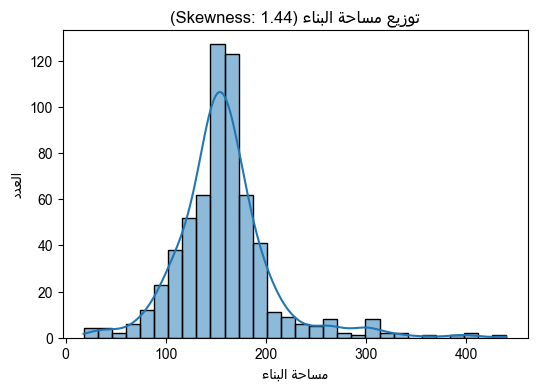

السعر بالشيكل: 5.49


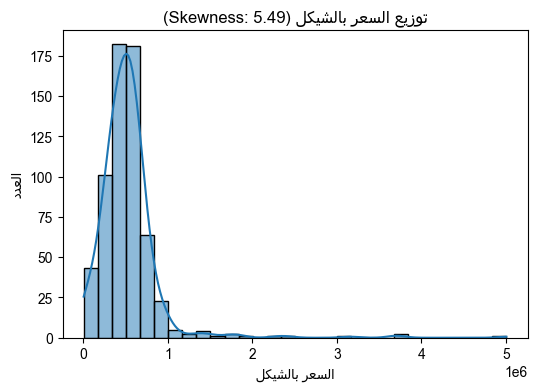

In [80]:
# Select numeric columns
target_cols = ["مساحة البناء", "السعر بالشيكل"]

print("📊 Skewness for Numeric Features:")
for col in target_cols:
    skew_val = df[col].skew()
    print(f"{col}: {skew_val:.2f}")
    
    # Plot histogram + KDE
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(process_arabic_text(f"توزيع {col} (Skewness: {skew_val:.2f})"))
    plt.xlabel(process_arabic_text(col))
    plt.ylabel(process_arabic_text("العدد"))
    plt.show()

We observe that the price distribution is highly right-skewed, so we will apply a power transformation to it.

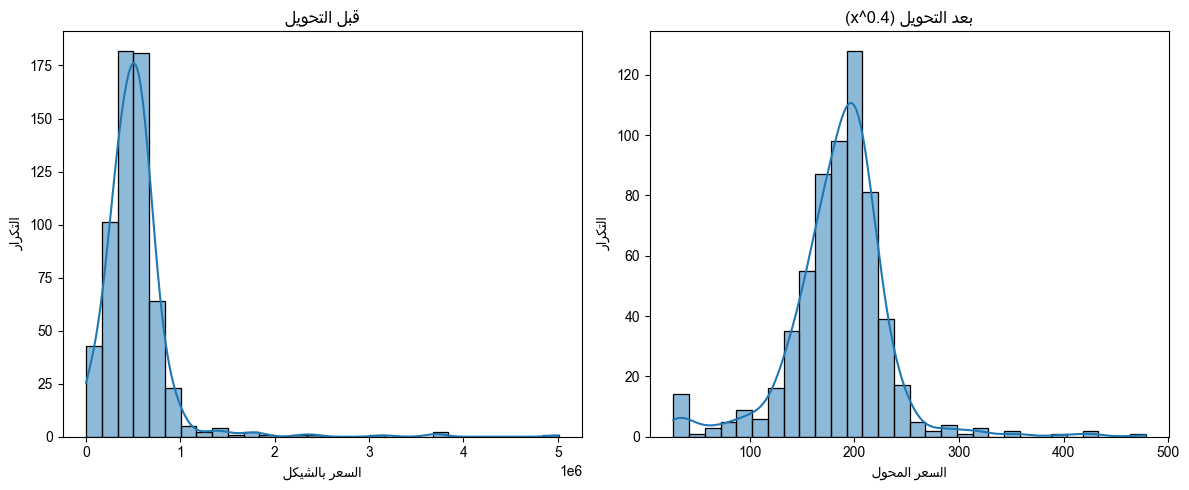

SKEWNESS COMPARISON:
Original skewness: 5.49
Transformed skewness: 0.24
Improvement: 5.25


In [81]:
original_skew = df["السعر بالشيكل"].skew()
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df["السعر بالشيكل"], kde=True, bins=30)
plt.title(process_arabic_text("قبل التحويل"))
plt.xlabel(process_arabic_text("السعر بالشيكل"))
plt.ylabel(process_arabic_text("التكرار"))

transformed_price = df["السعر بالشيكل"] ** 0.4
plt.subplot(1, 2, 2)
sns.histplot(transformed_price, kde=True, bins=30)
plt.title(process_arabic_text("بعد التحويل (x^0.4)"))
plt.xlabel(process_arabic_text("السعر المحول"))
plt.ylabel(process_arabic_text("التكرار"))

plt.tight_layout()
plt.show()

print("="*50)
print("SKEWNESS COMPARISON:")
print(f"Original skewness: {original_skew:.2f}")
print(f"Transformed skewness: {transformed_price.skew():.2f}")
print(f"Improvement: {original_skew - transformed_price.skew():.2f}")
print("="*50)

df["السعر بالشيكل"] = df["السعر بالشيكل"] ** 0.4